neural_net.py를 여기에 포함시켰습니다.

# Implementing a Neural Network
In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

In [0]:
import numpy as np
import matplotlib.pyplot as plt

class TwoLayerNet(): # input - fully connected layer - ReLU - fully connected layer - softmax
    def __init__(self, input_size, hidden_size, output_size, std=1e-4):

        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def loss(self, X, y=None, reg=0.0):

        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        N = X.shape[0]
        
        # Compute the forward pass
        Z1 = np.dot(X, W1) + b1
        A1 = np.maximum(0, Z1)
        Z2 = np.dot(A1, W2) + b2       
        if y is None:
            return Z2

        # Compute the loss
        scores_exp = np.exp(Z2)
        scores_expsum = np.sum(scores_exp, axis=1, keepdims=True)
        loss = -np.sum(Z2[range(N), y])
        loss += np.sum(np.log(scores_expsum))
        loss /= N
        loss += reg * (np.sum(W1*W1) + np.sum(W2*W2))
        
        # Backward pass: compute gradients
        grads = {}
        dZ2 = np.zeros(Z2.shape)
        dZ2[range(N), y] = -1
        dZ2 += scores_exp / scores_expsum
        grads['W2'] = np.dot(A1.T, dZ2) / N + 2 * reg * W2
        grads['b2'] = np.sum(dZ2, axis=0) / N
        
        dA1 = np.dot(dZ2, W2.T)
        dA1[Z1<=0] = 0
        dZ1 = dA1
        grads['W1'] = np.dot(X.T, dZ1) / N + 2 * reg * W1
        grads['b1'] = np.sum(dZ1, axis=0) / N

        return loss, grads

## 구현이 잘 되었는지 점검하기

In [0]:
# 구현이 제대로 되었는지 확인하기 위한 임시 모델 생성

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

### Forward pass: compute scores


In [3]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720745909845e-08


### Forward pass: compute loss

In [4]:
loss, _ = net.loss(X, y, reg=0.05)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
1.7963408538435033e-13


### Backward pass


In [5]:
from gradient_check import eval_numerical_gradient

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W2 max relative error: 3.440708e-09
b2 max relative error: 4.447656e-11
W1 max relative error: 3.561318e-09
b1 max relative error: 1.555471e-09


# Train the network
To train the network we will use stochastic gradient descent (SGD), similar to the SVM and Softmax classifiers. 

In [0]:
class TwoLayerNet(TwoLayerNet):
    def train(self, X, y, X_val, y_val, learning_rate=1e-3, learning_rate_decay=0.95,
              reg=5e-6, num_iters=100, batch_size=200, verbose=False):
        
        num_train = X.shape[0]
        iterations_per_epoch = max(num_train / batch_size, 1)

        loss_history = []
        train_acc_history = []
        val_acc_history = []

        for it in range(num_iters):
            batch_index = np.random.choice(range(num_train), batch_size)
            X_batch = X[batch_index]
            y_batch = y[batch_index]

            # Compute loss and gradients using the current minibatch
            loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
            loss_history.append(loss)
            
            # SGD
            self.params['W1'] -= learning_rate * grads['W1']
            self.params['b1'] -= learning_rate * grads['b1']
            self.params['W2'] -= learning_rate * grads['W2']
            self.params['b2'] -= learning_rate * grads['b2']
            
            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))
            
            if it % iterations_per_epoch == 0:
                # Check accuracy
                train_acc = (self.predict(X_batch) == y_batch).mean()
                val_acc = (self.predict(X_val) == y_val).mean()
                train_acc_history.append(train_acc)
                val_acc_history.append(val_acc)

                # Decay learning rate
                learning_rate *= learning_rate_decay

        return {
          'loss_history': loss_history,
          'train_acc_history': train_acc_history,
          'val_acc_history': val_acc_history,
        }

    def predict(self, X):
        scores = self.loss(X)
        y_pred = np.argmax(scores, axis=1)
        return y_pred

Final training loss:  0.017149607938731846


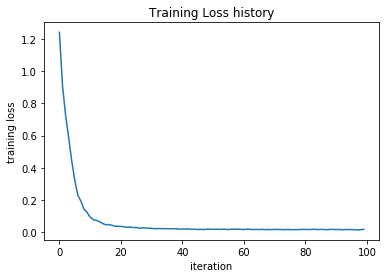

In [7]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Load the data
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [8]:
from keras.datasets import cifar10  

# 데이터 전처리 방식은 이전과 같다.
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)

num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# subsample the data
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask].astype('float64')
y_val = y_train[mask]
mask = range(num_training)
X_train = X_train[mask].astype('float64')
y_train = y_train[mask]
mask = range(num_test)
X_test = X_test[mask].astype('float64')
y_test = y_test[mask]

# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

# Normalize the data: subtract the mean image
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Using TensorFlow backend.


Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# Train a network
To train our network we will use SGD. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [9]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 1000: loss 2.302954
iteration 100 / 1000: loss 2.302550
iteration 200 / 1000: loss 2.297648
iteration 300 / 1000: loss 2.259602
iteration 400 / 1000: loss 2.204170
iteration 500 / 1000: loss 2.118565
iteration 600 / 1000: loss 2.051535
iteration 700 / 1000: loss 1.988466
iteration 800 / 1000: loss 2.006591
iteration 900 / 1000: loss 1.951473
Validation accuracy:  0.287


# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

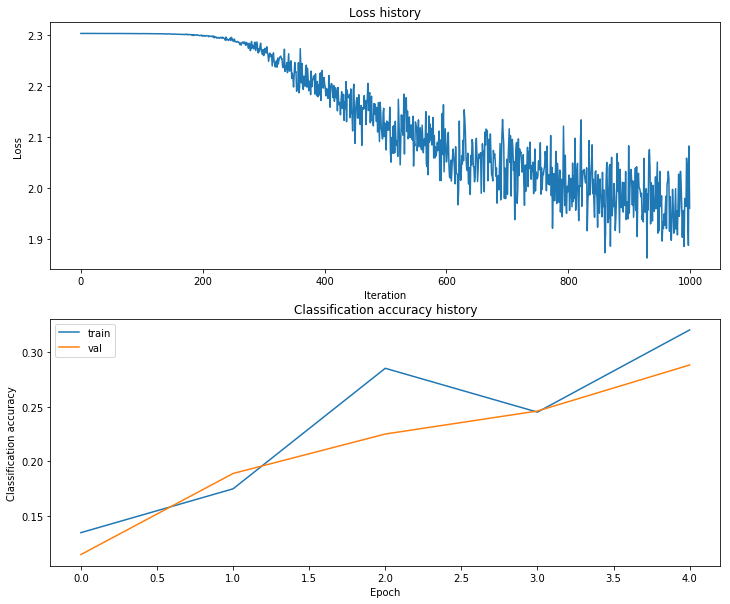

In [10]:
# Plot the loss function and train / validation accuracies
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

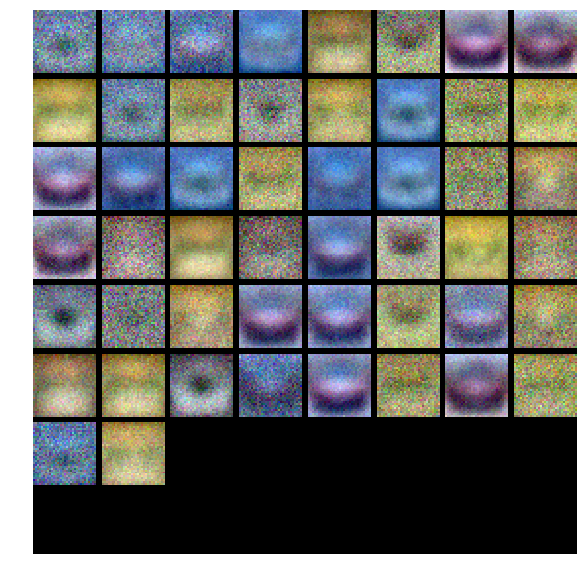

In [11]:
from vis_utils import visualize_grid

# Visualize the weights of the network
def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()
plt.figure(figsize=(10, 10))
show_net_weights(net)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: Your goal in this exercise is to get as good of a result on CIFAR-10 as you can (52% could serve as a reference), with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

In [12]:
best_net = None # store the best model into this 
best_val_acc = 0
best_params = ()
best_stats = None

input_size = 32 * 32 * 3
num_classes = 10

hidden_size = 100, 200, 400
learning_rate = 5e-4, 1e-3, 2e-3
reg = 0.25, 0.5, 1.

for h in hidden_size:
    print("===========")
    for l in learning_rate:
        print("-----------")
        for r in reg:
            net = TwoLayerNet(input_size, h, num_classes)
            stats = net.train(X_train, y_train, X_val, y_val, num_iters=1000, batch_size=200,
                                learning_rate=l, learning_rate_decay=0.95, reg=r, verbose=False)
            print('hidden_size: %d, learning_rate: %e, reg: %.2f' %(h, l, r))
            val_acc = (net.predict(X_val) == y_val).mean()
            print('Validation accuracy: %f \n' %val_acc)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_net = net
                best_stats = stats
                best_params = (h, l, r)

val_acc = (best_net.predict(X_val) == y_val).mean()
print('Best validation accuracy: ', val_acc)
print('hidden_size: %d, learning_rate: %e, reg: %.2f' %(best_params[0], best_params[1], best_params[2]))

-----------
hidden_size: 100, learning_rate: 5.000000e-04, reg: 0.25
Validation accuracy: 0.452000 

hidden_size: 100, learning_rate: 5.000000e-04, reg: 0.50
Validation accuracy: 0.453000 

hidden_size: 100, learning_rate: 5.000000e-04, reg: 1.00
Validation accuracy: 0.443000 

-----------
hidden_size: 100, learning_rate: 1.000000e-03, reg: 0.25
Validation accuracy: 0.485000 

hidden_size: 100, learning_rate: 1.000000e-03, reg: 0.50
Validation accuracy: 0.470000 

hidden_size: 100, learning_rate: 1.000000e-03, reg: 1.00
Validation accuracy: 0.457000 

-----------
hidden_size: 100, learning_rate: 2.000000e-03, reg: 0.25
Validation accuracy: 0.475000 

hidden_size: 100, learning_rate: 2.000000e-03, reg: 0.50
Validation accuracy: 0.464000 

hidden_size: 100, learning_rate: 2.000000e-03, reg: 1.00
Validation accuracy: 0.448000 

-----------
hidden_size: 200, learning_rate: 5.000000e-04, reg: 0.25
Validation accuracy: 0.460000 

hidden_size: 200, learning_rate: 5.000000e-04, reg: 0.50
Valid

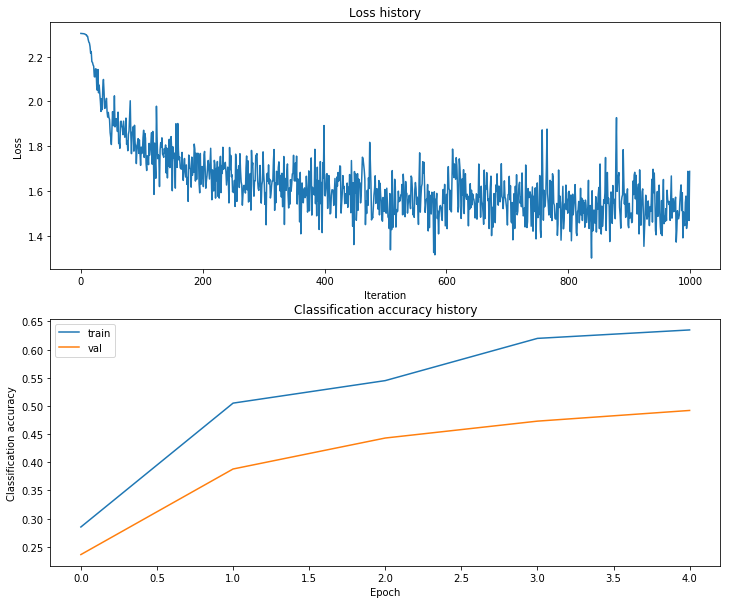

In [14]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.plot(best_stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(best_stats['train_acc_history'], label='train')
plt.plot(best_stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

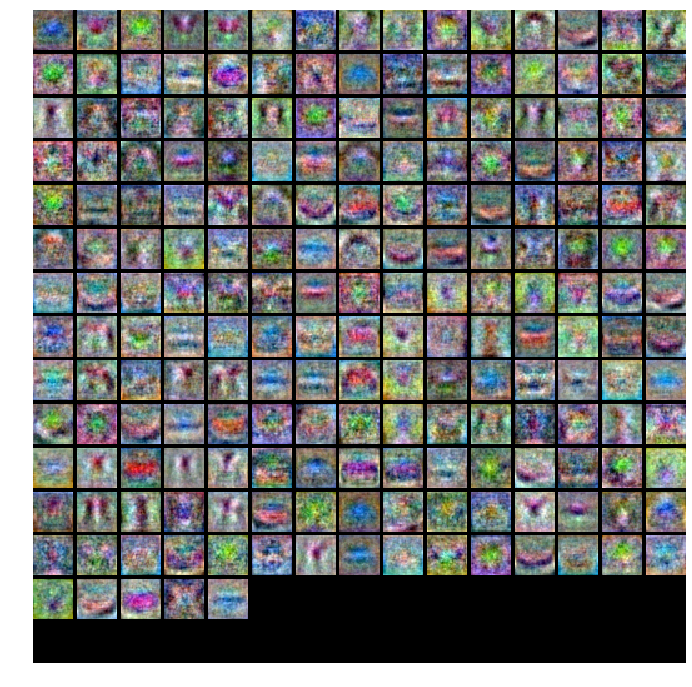

In [15]:
# visualize the weights of the best network
plt.figure(figsize=(12, 12))
show_net_weights(best_net)

# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

In [16]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.487
